In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from glob import glob
from tqdm import tqdm
import cv2

# Reference : [Original Notebook](https://www.kaggle.com/frlemarchand/generate-masks-from-weak-image-level-labels)

https://www.kaggle.com/frlemarchand/generate-masks-from-weak-image-level-labels  
I refer to this notebook.  
I study many function, code and knowledge based on this notebook.
And then I add more information and knowledge by myself.    

Thanks for   
[@Francois Lemarchand](https://www.kaggle.com/frlemarchand)

### 이 노트북은 학습을 위해 위의 참조 노트북을 참고하고, 번역하였으며, 추가로 공부한 내용과 지식을 정리한 노트북입니다.

## Introduction

이 노트북은 데이터를 불러오는 몇몇 함수들을 소개하는 것과, 학습 이미지에 존재하는 모든 세포의 클래스별 마스크를 생성하는 것을 목표로 합니다.   
각 클래스별 마스크(instance segmentation masks) 를 생성함으로써, 우리는 세포를 개별적으로 분석할 수 있고, 전체 이미지를 대상으로 주어진 한개 또는 여러개의 레이블과 연관지어볼 수 있습니다.  

In [2]:
data_dir = '../input/hpa-single-cell-image-classification/'
train_dir = data_dir + 'train/'
train_df = pd.read_csv("../input/hpa-single-cell-image-classification/train.csv")
train_df

,ID,Label
0,5c27f04c-bb99-11e8-b2b9-ac1f6b6435d0,8|5|0
1,5fb643ee-bb99-11e8-b2b9-ac1f6b6435d0,14|0
2,60b57878-bb99-11e8-b2b9-ac1f6b6435d0,6|1
3,5c1a898e-bb99-11e8-b2b9-ac1f6b6435d0,16|10
4,5b931256-bb99-11e8-b2b9-ac1f6b6435d0,14|0
...,...,...
21801,dd0989c4-bbca-11e8-b2bc-ac1f6b6435d0,14
21802,dd1f7fb8-bbca-11e8-b2bc-ac1f6b6435d0,3|0
21803,dd5cb36a-bbca-11e8-b2bc-ac1f6b6435d0,14|0
21804,df573730-bbca-11e8-b2bc-ac1f6b6435d0,14


# Load the images and apply a binary mask

In [3]:
def get_binary_mask(img):
    """ key : RGB 이미지를 Gray scale 이미지로 변환하는 함수
    
        < get_binary_mask 함수 >
        이진 segmentation (각 픽셀을 이진으로 분류하는 것 = 흑백으로 분류)을 하기 위해 
        Otsu threshold를 적용하기 전,
        RGB 이미지를 gray scale 이미지로 바꾸는 함수
        
        - 각 픽셀을 이진으로 분류하기 위해서는 gray scale 이미지가 필요
        - Otsu threshold : 픽셀을 이진 분류하는 otsu threshold.
    """
    blurred_img = cv2.GaussianBlur(img, (25,25), 0)
    gray_img = cv2.cvtColor(blurred_img, cv2.COLOR_RGBA2GRAY)
    ret, otsu = cv2.threshold(gray_img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    kernel = np.ones((40,40), np.uint8)
    closed_mask = cv2.morphologyEx(otsu, cv2.MORPH_CLOSE, kernel) # img, opening 방식, kernel 사이즈
    
    return closed_mask

# 이미지를 otsu threshold에 기반한 grayscale 이미지로 바꾼후, 
# 노이즈 제거를 한번 해준 mask(binary segmentation image)를 리턴

### [Otsu threshold](https://opencv-python.readthedocs.io/en/latest/doc/09.imageThresholding/imageThresholding.html)

```py
cv2.threshold(src, thres, maxval, type)
- src : input_image 로 single_channel 이미지 (그레이 스케일)
- thresh : 임계값
- maxval : 임계값을 넘었을 때 적용할 value
- type : thresholding type : type 에 따라 이진 색깔의 타입을 지정할 수 있다.

cv2.adaptiveThreshold(src, maxValue, adaptiveMethod, thresholdType, blockSize, C)
- 일부 영역이 완전히 흰색 또는 검정색으로 보여지므로 이것을 해결하기 위한 함수
```

Otsu 의 이진화  
: thresholding 처리에서 임계값은 사용자가 결정하여 parameter 로 전달. by trial and error 방식  
: bimodal image(히스토그램으로 분석하면 2개의 peak 가 있는 이미지)의 경우는 히스토그램에서 임계값을 어느정도 정확히 계산할 수 있다.  

Otsu의 이진화(Otsu's Binarization)란 bimodal image 에서 임계값을 자동으로 계산해주는 것.

### [cv2.morphologyEx](https://webnautes.tistory.com/1257)
OpenCV 에서 제공하는 함수 : Erosion, Dilation, Opening, Closing  
1. Erosion : 바이너리 이미지에서 흰색 '오브젝트'의 외곽 픽셀을 0(검은색)으로 만든다.(사진 전체의 외곽 X) = 가늘게
2. Dilation : Erosion 과 반대. 흰색 오브젝트의 외곽 픽셀을 1로 만든다. = 두껍게
3. Opening : Erosion 연산 다음에 Dilation 연산을 적용.(한번 지우고도 존재하는 것들을 두껍게) 이미지 상의 노이즈(작은 흰색)를 제거하는데 사용 
4. Closing : Dilation 연산 다음에 Erosion 연산을 적용. 흰색 오브젝트에 있는 작은 검은색 구멍들을 메우는데 사용.
```py
cv2.erode()
cv2.dilate()
cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel)
cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel)
```  
kernel : filter 크기

In [4]:
def load_RGBY_image(image_id_path):
    """ key : 모든 색상의 이미지를 합한 array 를 리턴. 
        Load and stack the channels that are stored separately.
    """
    red_image = cv2.imread(image_id_path+"_red.png", cv2.IMREAD_UNCHANGED)
    green_image = cv2.imread(image_id_path+"_green.png", cv2.IMREAD_UNCHANGED)
    blue_image = cv2.imread(image_id_path+"_blue.png", cv2.IMREAD_UNCHANGED)
    yellow_image = cv2.imread(image_id_path+"_yellow.png", cv2.IMREAD_UNCHANGED)

    stacked_images = np.transpose(np.array([red_image, green_image, blue_image, yellow_image]), 
                                  (1,2,0))
    
    return stacked_images

# cv2.IMREAD_UNCHANGED : alpha channel 포함. source image 로 읽어들임 ARGB
# TODO : 근데 여기선 왜 1차원이지?
# np.transpose : W x H x C -> C x W x H 로 변경

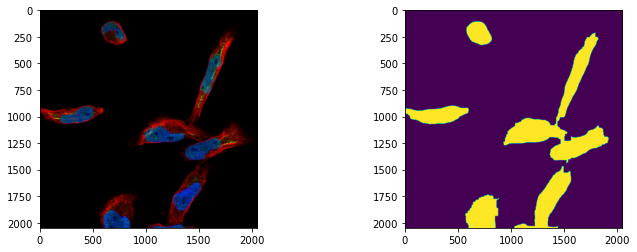

In [8]:
fig, axes = plt.subplots(1,2,figsize=(12,4))
axes[0].imshow(stacked_images[:,:,:3]) # RGB image
axes[1].imshow(binary_mask)
plt.show();

In [9]:
cv2.imread(image_id_path+'_red.png', cv2.IMREAD_COLOR).shape

(2048, 2048, 3)

In [10]:
# sample 확인
image_id_path = train_dir + train_df.iloc[0]['ID']
stacked_images = load_RGBY_image(image_id_path) # 4 channel : red, green, blue, yellow
binary_mask = get_binary_mask(stacked_images)

print(f"stacked_images.shape : {stacked_images.shape}\nbinary_mask.shape : {binary_mask.shape}")

stacked_images.shape : (2048, 2048, 4)
binary_mask.shape : (2048, 2048)


binary mask 는 RGB+Y 이미지를 기준으로 binary masking 을 통해 추출.

## Generate instance masks and convert to RLE encoding
```py
def rle_encoding(x)
def get_instance_masks(binary_mask)
```

In [11]:
def rle_encoding(x):
    
    """ Run-length encoding : https://en.wikipedia.org/wiki/Run-length_encoding
    
        마스크를 저장하기 쉬운 형식으로 바꾸는 것
        RLE encoding 된 마스크를 모델에 input 시킨다.
        
        ex) WWWBBBBWWCCCCCC = 3W4B2W6C
    """
    
    dots = np.where(x.T.flatten() == 255)[0]
    run_lengths = []
    prev = -2
    
    for b in dots:
        if (b > prev + 1):
            run_lengths.extend((b+1, 0))
        run_lengths[-1] += 1
        prev = b # 한칸 이상 동떨어져 있을 경우 length 리셋
        
    return ' '.join([str(x) for x in run_lengths])

In [12]:
def get_instance_masks(binary_mask):
    """
        바이너리 마스크를 input 받아서,
        작은 아이템은 걸러내고, 큰 binary larget object 의 독립된 마스크를 생성한다.
    """
    contours = cv2.findContours(binary_mask, 
                                cv2.RETR_TREE,
                                cv2.CHAIN_APPROX_SIMPLE)
    instance_masks = []
    for contour in contours[0]:
        if cv2.contourArea(contour) > 100: # 형태의 넓이 구하기
            instance_contour = np.zeros(binary_mask.shape) # 일단 전체 이미지 크기만큼
            cv2.drawContours(instance_contour, [contour], 
                             0, 255, thickness = cv2.FILLED)
            
            encoded_cell_mask = rle_encoding(instance_contour)
            instance_masks.append(encoded_cell_mask)
            
    return instance_masks
    
# parameter 설명은 링크참조
# cv2.RETR_TREE : 모든 contours line 을 찾으며, 모든 hierachy 관계를 구성함.
# cv2.CHAIN_APPROX_SIMPLE : contours line 을 그릴 수 있는 point 만 저장(ex: 사각형이면 4개 포인트)

### [Contours](https://opencv-python.readthedocs.io/en/latest/doc/15.imageContours/imageContours.html) 
: cv2.findContours, cv2.contourArea, cv2.drawContours    

* **contours** : 동일한 색 또는 동일한 강도를 가지고 있는 영역의 경계선을 연결한 선 : like 등고선
    - 정확도를 높히기 위해서 Binary Image 를 사용. Threshold 나 canny edge 를 선처리로 수행
    - `cv2.findContours()` 함수는 원본 이미지를 직접 수정하기 때문에, 원본 이미지를 보존하려면 Copy 해서 사용
    - OpenCV 에서는 contours 를 찾는 것은 검은색 배경에서 하얀색 대상을 찾는 것. So, 대상 = 흰색, 배경 = 검은색

**Find & Draw Contours**
```py
cv2.findContours(image, mode, method[, contours[, hierarchy[, offset]]]) → image, contours, hierarchy

cv2.drawContours(image, contours, contourIdx, color[, thickness[, lineType[, hierarchy[, maxLevel[, offset]]]]]) → dst

# parameter 는 링크 참조
```

[이미지 Contour 응용 링크](https://m.blog.naver.com/PostView.nhn?blogId=samsjang&logNo=220516822775&proxyReferer=https:%2F%2Fwww.google.com%2F)

## Add the RLE encoding to the existing training dataframe

train_df 에 RLE encoding 값을 추가하자

### 1) 제대로 된 시작 전에 각 과정을 하나하나 뜯어보자

In [13]:
train_df[:20].head(5) # iterrows 로 행을 하나씩 불러올 dataframe

,ID,Label
0,5c27f04c-bb99-11e8-b2b9-ac1f6b6435d0,8|5|0
1,5fb643ee-bb99-11e8-b2b9-ac1f6b6435d0,14|0
2,60b57878-bb99-11e8-b2b9-ac1f6b6435d0,6|1
3,5c1a898e-bb99-11e8-b2b9-ac1f6b6435d0,16|10
4,5b931256-bb99-11e8-b2b9-ac1f6b6435d0,14|0


In [14]:
# 아래 process 예시 및 시각화
for idx, item in train_df.iterrows():
    image_id_path = train_dir+item.ID
    break
    
stacked_images = load_RGBY_image(image_id_path)
binary_mask = get_binary_mask(stacked_images)
instance_masks = get_instance_masks(binary_mask)

print(f"stacked_images.shape : {stacked_images.shape}\nbinary_mask.shape : {binary_mask.shape}")

stacked_images.shape : (2048, 2048, 4)
binary_mask.shape : (2048, 2048)


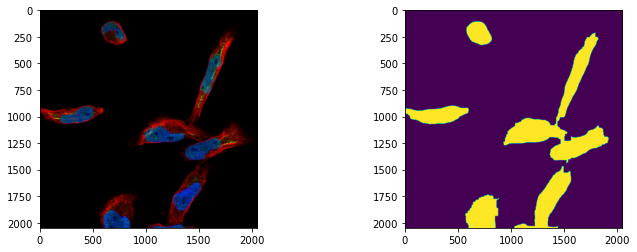

In [15]:
fig, axes = plt.subplots(1,2,figsize=(12,4))
axes[0].imshow(stacked_images[:,:,:3]) # RGB image
axes[1].imshow(binary_mask)
plt.show();

In [16]:
# get_instance_mask 함수 내부

# contours (라인 따내기)
contours = cv2.findContours(binary_mask, # image
                            cv2.RETR_TREE, # contours 라인, 모든 hierachy 관계 구성 = 모든 경계에 컨투어를 그림
                            cv2.CHAIN_APPROX_SIMPLE) 
# contours line 을 그릴 수 있는 포인트 저장, 4각형은 4개. 많을 경우, 말 그대로 많기 때문에.
contours[1]

array([[[ 1, -1, -1, -1],
        [ 2,  0, -1, -1],
        [ 3,  1, -1, -1],
        [ 4,  2, -1, -1],
        [-1,  3, -1, -1]]], dtype=int32)

contours[1] = hierachy

|인덱스|다음(next)|이전(prev)|자식(First Child)|부모(parent)|
|:-|:-:|:-:|:-:|:-:|
|0|1|-1|-1|-1|
|1|2|0|-1|-1|
|2|3|1|-1|-1|
|3|4|2|-1|-1|
|4|-1|3|-1|-1|

|인덱스|행|의미|다음|이전|
|:-:|:-:|:-:|:-:|:-:|
|인덱스 0 | 0번째 행 | 첫 번째 도형의 컨투어 | 1 = 다음 도형은 1행| 의미없음 |
|인덱스 1 | 1번째 행 | 두 번째 도형의 컨투어 | 2 = 다음 도형은 2행| 0 = 이전 도형은 0행|
|인덱스 2 | 2번째 행 | 세 번째 도형의 컨투어 | 3 = 다음 도형은 3행| 1 = 이전 도형은 1행|
|인덱스 3 | 3번째 행 | 네 번째 도형의 컨투어 | 4 = 다음 도형은 4행| 2 = 이전 도형은 2행|
|인덱스 4 | 4번째 행 | 다섯 번째 도형의 컨투어 | -1 = 다음 도형은 없음| 3 = 이전 도형은 3행|



-1 : 의미없음  
(이 contours hierachy 에서는 자식과 부모가 모두 -1 이므로 표 설명에서 제외함)

자식과 부모 관련 계층은 참고링크 참조 :
[참고 링크](https://bkshin.tistory.com/entry/OpenCV-22-%EC%BB%A8%ED%88%AC%EC%96%B4Contour)

<img src = 'https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FlDtdX%2FbtqHq2Q5eFD%2F1UqKRIEGFO81aGSIfwccIk%2Fimg.png' width = 300 height = 300 align = left>  

이처럼 그림을 그릴 경우 번개 하나에 다양한 방식으로 컨투어를 감싸는 그림을 그릴 수 있음

In [17]:
for i in contours[0]:
    print(i.shape)
# 5개의 라인을 따냈다. = contours 는 검은색 배경에서 흰색을 찾는 것
# 한붓그리기로 그릴 수 있는 물체 덩어리를 총 5개 찾았다는 말.

(242, 1, 2)
(651, 1, 2)
(450, 1, 2)
(2023, 1, 2)
(350, 1, 2)


예정된 코드 예시
```py
instance_masks = []
for contour in contours[0]: # 현재 5개
    if cv2.contourArea(contour) > 100: # 찾은 영역이 매우 작다면, 패스하겠다.
        instance_contour = np.zeros(binary_mask.shape) # contour 마다 새로운 도화지
        # 일단 전체 이미지 크기만큼 0 array생성(배경) = 윤곽선 그리기 준비
        cv2.drawContours(instance_contour, # 입력 영상(검은색 도화지)
                         [contour],        # 그림 그릴 컨투어 배열 = contours
                         0,                # 그림 그릴 컨투어 인덱스 = contours[0]
                         255,              # 색상 값 = 여기서는 흰색으로 통일
                         thickness = cv2.FILLED)
        
        encoded_cell_mask = rle_encoding(instance_contour) # 
        instance_masks.append(encoded_cell_mask)
```

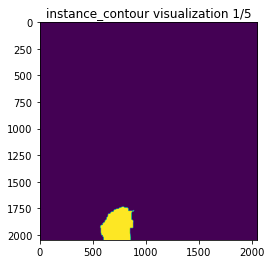

In [18]:
# contours 5 개 중 하나씩 테스트 시각화 해보자
instance_masks = []
contour = contours[0][0] # 1/5
if cv2.contourArea(contour) > 100:
    instance_contour = np.zeros(binary_mask.shape)
    cv2.drawContours(instance_contour, [contour], 0, 255, thickness = cv2.FILLED)
    
plt.imshow(instance_contour)
plt.title('instance_contour visualization 1/5')
plt.show();

In [19]:
print(f"instance_contou unique value : {np.unique(instance_contour)}")
print(f"instance_contour.shape : {instance_contour.shape}")
all_pixels = instance_contour.shape[0] * instance_contour.shape[1]
print(f"all pixel length : {all_pixels}")

instance_contou unique value : [  0. 255.]
instance_contour.shape : (2048, 2048)
all pixel length : 4194304


In [20]:
# RLE_encoding 함수 안으로

total = len(np.where(instance_contour.T.flatten() == 255)[0])
print(f"흰색인 인덱스의 픽셀 수 : {total}")
print(f"비율 : {(total / all_pixels):.4f}")
dots = np.where(instance_contour.T.flatten() == 255)[0]
print(f"\n dots(index) : {dots}")
print(f"\tdots : instance contour 를 전치하고 flatten 시킨 후, 흰색인 것들의 인덱스 값만 뽑아낸 것")

흰색인 인덱스의 픽셀 수 : 74379
비율 : 0.0177

 dots(index) : [1159052 1161088 1161089 ... 1810152 1810153 1810154]
	dots : instance contour 를 전치하고 flatten 시킨 후, 흰색인 것들의 인덱스 값만 뽑아낸 것


In [21]:
# x = instance_contour
run_lengths = []
prev = -2
for b in dots:
    if (b > prev + 1):               # b 가 0 이상이면, 
        run_lengths.extend((b+1, 0)) #  
    run_lengths[-1] += 1
    prev = b
rle_sample = ' '.join([str(x) for x in run_lengths])
len(rle_sample)

4006

In [22]:
rle_sample[:500]
# encoded_cell_mask = rle_encoding(instance_contour)
# encoded_cell_mask 
# 이 과정을 거친 것

'1159053 1 1161089 14 1163133 18 1165179 21 1167225 23 1169273 23 1171319 25 1173366 69 1175414 73 1177461 77 1179509 88 1181557 91 1183604 93 1185652 94 1187700 95 1189748 96 1191796 96 1193843 97 1195891 97 1197939 97 1199987 97 1202034 98 1204081 99 1206117 111 1208164 123 1210212 124 1212260 125 1214308 126 1216355 128 1218402 130 1220448 134 1222494 140 1224540 165 1226587 166 1228634 167 1230682 167 1232730 167 1234778 167 1236826 167 1238874 167 1240922 167 1242970 167 1245018 167 1247065 '

### 결론

이러한 과정을 4번 더 반복하여 이미지에 해당하는 하나의 rle_encoding 총집합 을 만든다.

### 2) 프로세스 진행

In [23]:
process_RLE_for = 20
train_df["RLE_encoding"] = ""

with tqdm(total=process_RLE_for) as pbar: 
    for idx, item in train_df[:process_RLE_for].iterrows():
        image_id_path = train_dir+item.ID

        stacked_images = load_RGBY_image(image_id_path)
        binary_mask = get_binary_mask(stacked_images)
        instance_masks = get_instance_masks(binary_mask)

        train_df.at[idx, "RLE_encoding"] = str(instance_masks)
        pbar.update(1) # to 20(total)
        
        
# iterrows : 첫 번째 변수 idx 에 인덱스를 받고, item 은 열의 행에 하나씩 접근하여 출력

100%|██████████| 20/20 [01:40<00:00,  5.02s/it]


Manual control of `tqdm()` updates using a `with` statement:    
with 구문을 사용해서 tqdm 을 수동으로 컨트롤한다. update() 로 수동으로 진행률을 증가시킨다.  
```py
with tqdm(total=100) as pbar:
    for i in range(10):
        sleep(0.1)
        pbar.update(10)
-------------------------------------
pbar = tqdm(total=100)
for i in range(10):
    sleep(0.1)
    pbar.update(10)
pbar.close()
```
[link](https://github.com/tqdm/tqdm)

In [24]:
train_df.loc[15:25] # 20개만 했으므로

,ID,Label,RLE_encoding
15,5f005cfa-bb99-11e8-b2b9-ac1f6b6435d0,12,['3817468 5 3819513 8 3821558 11 3823604 13 38...
16,5beb608c-bb99-11e8-b2b9-ac1f6b6435d0,6,['1388542 3 1390588 5 1392634 7 1394680 9 1396...
17,636e164c-bb99-11e8-b2b9-ac1f6b6435d0,3,['2828938 9 2832005 14 2835075 16 2838144 57 2...
18,5b99d3e8-bb99-11e8-b2b9-ac1f6b6435d0,13,['1785 36 3833 36 5881 36 7929 36 9977 35 1202...
19,61ef3044-bb99-11e8-b2b9-ac1f6b6435d0,9|16|0|13,['4789248 1 4792319 2 4795391 2 4798463 2 4801...
20,5b88d5e8-bb99-11e8-b2b9-ac1f6b6435d0,14|2,
21,6074a6a4-bb99-11e8-b2b9-ac1f6b6435d0,0,
22,6388d7d4-bb99-11e8-b2b9-ac1f6b6435d0,15|0,
23,64ab5506-bb99-11e8-b2b9-ac1f6b6435d0,2,
24,643f73a4-bb99-11e8-b2b9-ac1f6b6435d0,14,


## 이미지 히스토그램

학습 이미지의 모든 세포에 대해 개별 마스크를 생성함으로써, 이미지 분석을 실시할 수 있다.   
아래는, 모든 세포와 RGB 채널의 색 분포를 시각화하였다.  
세포의 클래스를 분별하는 방법은 색 분포 signature 에 기반하여 clustering 하는 방법도 있다.

In [25]:
def plot_color_distribution(isolated_cell_img):
    color = ('r', 'g', 'b', 'y')
    for i, col in enumerate(color):
        histr = cv2.calcHist([isolated_cell_img],[i], None, [256], [1, 256])
        plt.plot(histr, color = col)
        plt.xlim([1, 256])
    plt.show();

### [Histogram (OpenCV, Matplotlib)](https://opencv-python.readthedocs.io/en/latest/doc/19.imageHistograms/imageHistograms.html)
OpenCV 와 Matplotlib 를 이용하여 Histogram 을 찾을 수 있다.

* Histogram : 이미지의 밝기의 분포를 그래프로 표현한 방식. 이미지 전체의 밝기 분포와 채도(색의 밝고 어두움)를 알 수 있다.
```py
cv2.calcHist(images, channels, mask, histSize, ranges[, hist[, accumulate]])
```
  
(좌측 이미지)  
2가지 이미지를 grayscale 로 읽어 빛의 세기 분포를 보여주는 예제(출처 : opencv-python.readthedocs.io)  
Red Line이미지는 전체적으로 어둡기 때문에 히스토그램에서 좌측의 분포가 높고, Green Line 이미지는 전체적으로 밝기 때문에 오른쪽의 분포가 높습니다. 

(우측 이미지)  
이미지의 특정영역의 히스토그램을 분석하기 위해서 mask 를 적용할 수 있다.  
red : 원본이미지 히스토그램, blue : mask 적용된 히스토그램

<img src = 'https://opencv-python.readthedocs.io/en/latest/_images/result0110.jpg' width = 500 height = 500 align = left>
<img src = 'https://opencv-python.readthedocs.io/en/latest/_images/result026.jpg' width = 500 height = 500 align = right>




In [26]:
def analyze_individual_cells(binary_mask, original_image): 
    
    contours = cv2.findContours(binary_mask,
                                cv2.RETR_TREE,
                                cv2.CHAIN_APPROX_SIMPLE)
    
    for contour in contours[0]:
        if cv2.contourArea(contour) > 100:
            x, y, width, height = cv2.boundingRect(contour)
            
            instance_contour = np.zeros(binary_mask.shape)
            cv2.drawContours(instance_contour, [contour], 0, 255, thickness = cv2.FILLED)
            
            isolated_cell_image = np.zeros(binary_mask.shape)
            isolated_cell_image = cv2.bitwise_and(original_image, original_image, mask = instance_contour.astype('uint8'))
            
            plt.imshow(isolated_cell_image[y : y+height, x : x+width, :3])
            plt.show()
            plot_color_distribution(isolated_cell_image[y:y+height, x:x+width])

### [비트연산](https://opencv-python.readthedocs.io/en/latest/doc/07.imageArithmetic/imageArithmetic.html)  
src1, src2, dis, mask
```py
cv2.bitwise_and()
cv2.bitwise_or()
cv2.bitwise_not()
cv2.bitwise_xor()
```
binary 이미지 2개를 가지고 비트연산을 수행한다.

---------

아래에서 보듯, 정의한 함수를 사용하여 개별 세포를 분리하려고 할 때, 우리는 세포가 서로 너무 가까이 있을 때 몇 가지 문제를 관찰할 수 있다.  

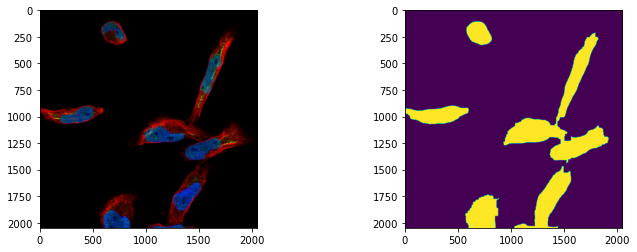

In [27]:
image_id_path = train_dir + train_df.iloc[0]['ID']
stacked_images = load_RGBY_image(image_id_path)
binary_mask = get_binary_mask(stacked_images)

fig, axes = plt.subplots(1,2,figsize=(12,4))
axes[0].imshow(stacked_images[:,:,:3]) # RGB image
axes[1].imshow(binary_mask)
plt.show();

In [28]:
# 비트연산 수행
contours = cv2.findContours(binary_mask,
                            cv2.RETR_TREE,
                            cv2.CHAIN_APPROX_SIMPLE)

original_image = stacked_images

contour = contours[0][0] # contours 중 첫 번째 하나로 시각화 시도
if cv2.contourArea(contour) > 100:
    x, y, width, height = cv2.boundingRect(contour) # contour bounding box 생성 (format = COCO)
    instance_contour = np.zeros(binary_mask.shape)
    cv2.drawContours(instance_contour, [contour], 0, 255, thickness = cv2.FILLED)

    isolated_cell_image = np.zeros(binary_mask.shape)
    isolated_cell_image = cv2.bitwise_and(original_image, original_image, mask = instance_contour.astype('uint8'))
            
print(f"isolated_cell_image.shape : {isolated_cell_image.shape}")

isolated_cell_image.shape : (2048, 2048, 4)


여기서 isolated_cell_image 는 contour 로 나눠진 독립된 한 등고선을 따라 존재하는 세포 덩어리

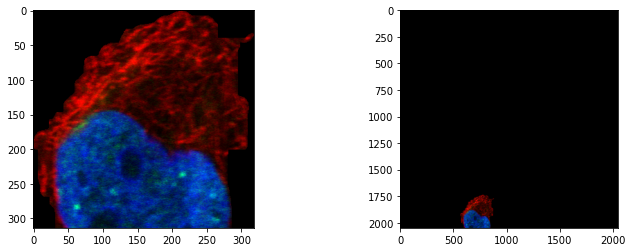

In [29]:
fig, axes = plt.subplots(1,2,figsize=(12,4))
axes[0].imshow(isolated_cell_image[y : y+height, x : x+width, :3]) # 확대버전
axes[1].imshow(isolated_cell_image[:,:,:3])
plt.show();

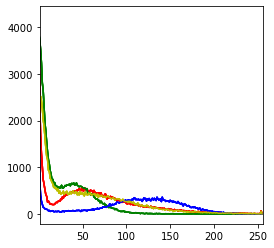

In [30]:
plt.figure(figsize=(4,4))
color = ('r', 'g', 'b', 'y')
for i, col in enumerate(color):
    for i, col in enumerate(color):
        histr = cv2.calcHist([isolated_cell_image],[i], None, [256], [1, 256]) 
        # isolated_cell_img 의 각 channel 에 대해 histogram 을 뽑아낸다.
        plt.plot(histr, color = col)
        plt.xlim([1, 256]) # RGB 수치
plt.show();

## 전체 contours 에 대해서 수행

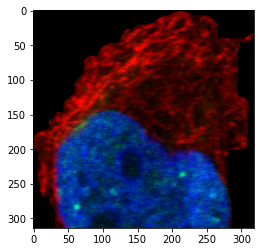

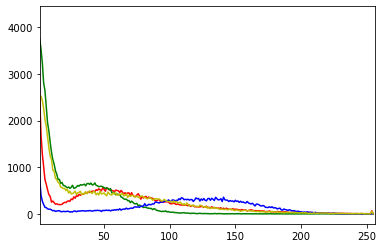

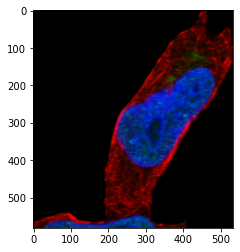

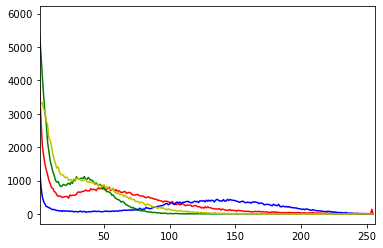

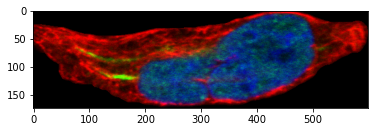

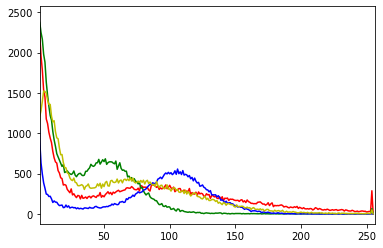

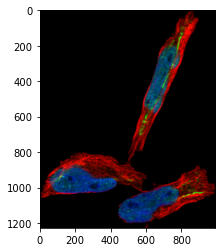

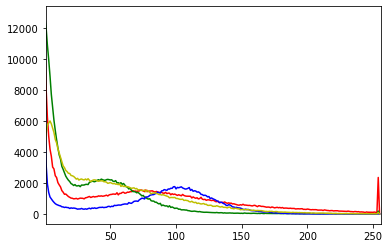

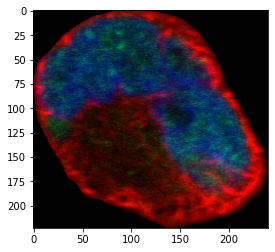

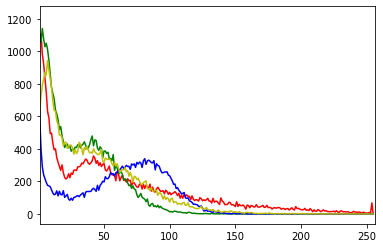

In [31]:
analyze_individual_cells(binary_mask, stacked_images)

### 배운점

이 노트북을 통해서 HPA task 자체보다는 기반이 되는 함수, image 를 다루는 것에 대해서 배웠다.  
task 는 다른 노트북을 통해서 어떻게 구체적으로 학습과 예측이 수행되는지, 정확한 task 는 무엇인지 공부해보자.  

In [32]:
#TODO : Tasks